In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cuadro0 = cv2.imread('img/cuadro_0.jpg', cv2.IMREAD_GRAYSCALE)
cuadro1 = cv2.imread('img/cuadro_1.jpg', cv2.IMREAD_GRAYSCALE)   # imagen ancla
cuadro2 = cv2.imread('img/cuadro_2.jpg', cv2.IMREAD_GRAYSCALE)

udesa0 = cv2.imread('img/udesa_0.jpg', cv2.IMREAD_GRAYSCALE)
udesa1 = cv2.imread('img/udesa_1.jpg', cv2.IMREAD_GRAYSCALE)  # imagen ancla
udesa2 = cv2.imread('img/udesa_2.jpg', cv2.IMREAD_GRAYSCALE)

 Detección y descripción de características visuales con SIFT aplicando ANMS

In [3]:

def apply_ANMS(keypoints, descriptors, N=200, c=0.9):
    response = np.array([kp.response for kp in keypoints])
    coords = np.array([kp.pt for kp in keypoints])
    radii = np.full(len(keypoints), np.inf)

    for i, kp1 in enumerate(keypoints):
        dists = np.linalg.norm(coords - coords[i], axis=1)
        mask = response > response[i] * c
        valid_dists = dists[mask]
        if len(valid_dists) > 0:
            radii[i] = valid_dists.min()

    indices = np.argsort(radii)[:N]
    filtered_keypoints = [keypoints[i] for i in indices]
    filtered_descriptors = descriptors[indices]

    return filtered_keypoints, filtered_descriptors

In [4]:
# Inicializamos SIFT
sift = cv2.SIFT_create()

def process_images(image1, image_anchor, N=200, ratio_threshold=0.75):

    #Redimensionar imagenes para ver si corre
    #image1 = cv2.resize(image1, (800, 600))
    #image_anchor = cv2.resize(image_anchor, (800, 600))
    
    # Keypoints y descriptores
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints_anchor, descriptors_anchor = sift.detectAndCompute(image_anchor, None)

    # Aplicamos ANMS a ambos conjuntos de puntos clave
    keypoints1, descriptors1 = apply_ANMS(keypoints1, descriptors1, N)
    keypoints_anchor, descriptors_anchor = apply_ANMS(keypoints_anchor, descriptors_anchor, N)

    # Flann Based Matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)  
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Hacer coincidir descriptores
    initial_matches = flann.knnMatch(descriptors1, descriptors_anchor, k=2)

    # Aplicamos la prueba de Lowe y la verificación cruzada
    good_matches = []
    for m, n in initial_matches:
        # Prueba de Lowe: distancia de m debe ser suficientemente menor que la distancia de n
        if m.distance < ratio_threshold * n.distance:
            # Verificación cruzada 
            reciprocal_matches = flann.knnMatch(descriptors_anchor[n.trainIdx].reshape(1, -1), descriptors1, k=1)
            if len(reciprocal_matches) == 1 and reciprocal_matches[0][0].trainIdx == m.queryIdx:
                good_matches.append(m)
    
    print(f"Total coincidencias: {len(good_matches)}")  # Debugging: imprime el número de coincidencias buenas

    img_matches = cv2.drawMatches(image1, keypoints1, image_anchor, keypoints_anchor, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return img_matches

Total coincidencias: 0
Total coincidencias: 0
Total coincidencias: 1
Total coincidencias: 0


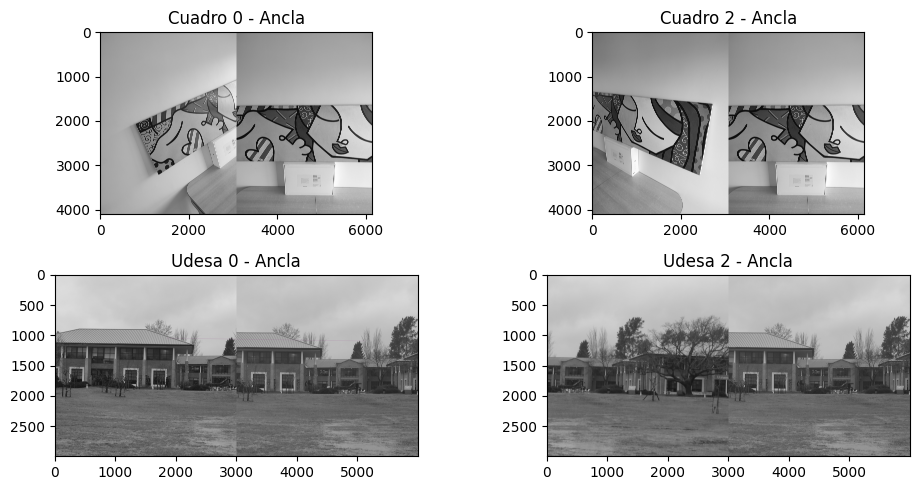

In [5]:

cuadro_matches_0 = process_images(cuadro0, cuadro1)
cuadro_matches_2 = process_images(cuadro2, cuadro1)
udesa_matches_0 = process_images(udesa0, udesa1)
udesa_matches_2 = process_images(udesa2, udesa1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(cuadro_matches_0, cmap='gray')
plt.title('Cuadro 0 - Ancla')

plt.subplot(2, 2, 2)
plt.imshow(cuadro_matches_2, cmap='gray')
plt.title('Cuadro 2 - Ancla')

plt.subplot(2, 2, 3)
plt.imshow(udesa_matches_0, cmap='gray')
plt.title('Udesa 0 - Ancla')

plt.subplot(2, 2, 4)
plt.imshow(udesa_matches_2, cmap='gray')
plt.title('Udesa 2 - Ancla')

plt.tight_layout()
plt.show()